# Residual analysis
This is a preliminary look into correlations between the residuals of the group contribution model. We hypothesise that there will be correlations in the residuals for reactions that share compounds with highly over or under-estimated dgf. We measure high under and over estimation by comparing the dgf estimates of the GC and CC models. 

In [1]:
from pathlib import Path
from equilibrator_api import ComponentContribution
from dgfreg.data_preparation import load_prepared_data
import arviz as az
import os
import matplotlib.pyplot as plt

ROOT_DIR = Path().absolute().parent
INFERENCES_DIR = ROOT_DIR / "inferences"
PLOTS_DIR = ROOT_DIR / "docs" / "plots"
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

cc = ComponentContribution()

var_names = {"gc_mean_resid": "Mean GC residuals",
             "tfm_cc_gc_diff": "Transformed GC dgf error",
             "cc_gc_diff": "GC dgf error",
             "resid_gc": "GC residuals"}             

In [2]:
dgr_gc = (cc.predictor.params.train_G.T @ cc.predictor.params.train_S).T @ cc.predictor.params.dG0_gc
dgr_cc = cc.predictor.params.train_S.T @ cc.predictor.params.dG0_cc
dgf_gc = cc.predictor.params.train_G @ cc.predictor.params.dG0_gc

prepped = load_prepared_data(Path.cwd().parent / "data" / "prepared" / "equilibrator")

measurements = prepped.measurements.set_index("measurement_id")
measurements["dgr_gc"] = dgr_gc
measurements["dgr_cc"] = dgr_cc
measurements["resid_gc"] = dgr_gc - measurements["y"]
measurements["resid_cc"] = dgr_gc - measurements["y"]

G = prepped.G.set_index(["compound_id", "group_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)
S = prepped.S.set_index(["compound_id", "reaction_id"])["stoichiometric_coefficient"].unstack().fillna(0.0)

compounds = prepped.compounds.set_index("compound_id")
compounds["dgf_gc"] = dgf_gc
compounds["cc_gc_diff"] = compounds["dgf_gc"] - compounds["dgf_cc"]

reactions = prepped.reactions.set_index("reaction_id")
reactions = reactions.join(measurements.groupby("reaction_id").agg({"y": ["mean", "count"]})["y"].add_prefix("y_"))
reactions["dgr_gc"] = measurements.groupby("reaction_id")["dgr_gc"].first()
reactions["dgr_cc"] = measurements.groupby("reaction_id")["dgr_cc"].first()
reactions["tfm_cc_gc_diff"] = S.T @ compounds["cc_gc_diff"]
reactions["gc_mean_resid"] = reactions["dgr_gc"] - reactions["y_mean"]
reactions["cc_mean_resid"] = reactions["dgr_cc"] - reactions["y_mean"]

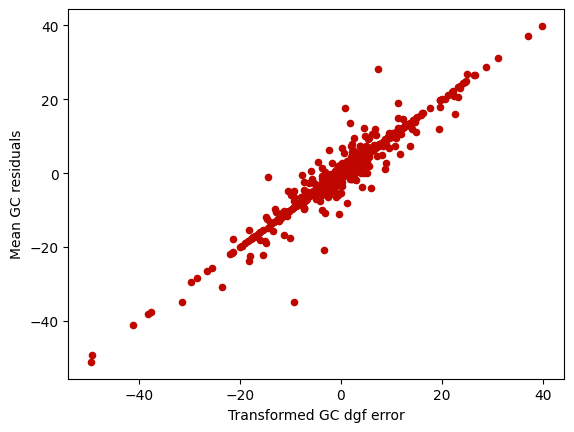

In [3]:
ax = reactions.rename(var_names, axis=1).plot.scatter(var_names["tfm_cc_gc_diff"], var_names["gc_mean_resid"]).get_figure()
ax.savefig((PLOTS_DIR / "tfm-mean-rxn-GC-err-resid-corr.png").absolute())

That looks too good to be true. Let's look first at the measurment residuals.

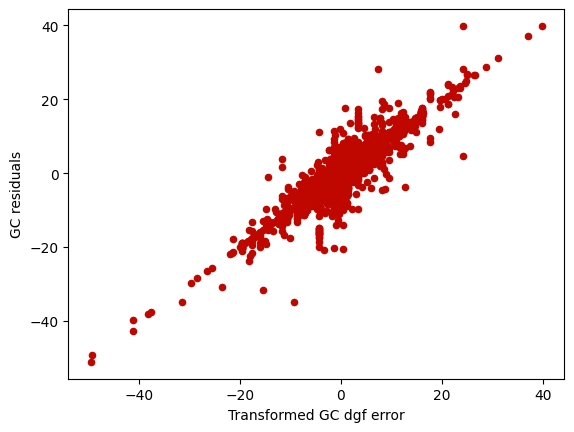

In [4]:
if not "cc_gc_diff" in measurements.columns:
    measurements = measurements.join(reactions["tfm_cc_gc_diff"], on="reaction_id")
ax = measurements.rename(var_names, axis=1).plot.scatter(var_names["tfm_cc_gc_diff"], var_names["resid_gc"]).get_figure()
ax.savefig((PLOTS_DIR / "tfm-mean-GC-err-resid-corr.png").absolute())

Huh, okay. Now let's look at a couple of key reactions

In [6]:
reactions.sort_values("tfm_cc_gc_diff").drop(["EC", "reaction"], axis=1)

,is_formation,is_e_coli_ccm,description,y_mean,y_count,dgr_gc,dgr_cc,tfm_cc_gc_diff,gc_mean_resid,cc_mean_resid
reaction_id,,,,,,,,,,
667,False,False,ubiquinone (n=1) redox,-101.673522,1,-152.764403,-103.291678,-49.472725,-51.090881,-1.618156e+00
473,True,False,L-Tyrosine formation,-370.656665,1,-419.948535,-370.656665,-49.291870,-49.291870,4.490630e-12
383,False,False,3-dehydroquinate(aq) = 3-dehydroshikimate(aq) ...,-5.290328,2,-46.407494,-5.290328,-41.117165,-41.117165,1.879386e-12
303,False,True,retinyl palmitate(aq) + H2O(l) = retinol(aq) +...,61.381868,1,23.142783,61.381868,-38.239086,-38.239086,-1.983125e-11
634,True,False,Hexachlorobenzene formation,46.000000,1,8.349892,46.000000,-37.650108,-37.650108,2.273737e-13
...,...,...,...,...,...,...,...,...,...,...
616,True,False,"1,1,1-Trichloroethane formation",-69.032937,1,-42.412459,-69.032937,26.620478,26.620478,-2.728484e-12
637,True,False,"2,5-Dichlorobenzoate formation",-278.723148,1,-249.954914,-278.723148,28.768234,28.768234,-7.958079e-13
476,True,False,Urea formation,-202.777248,1,-171.680751,-202.777248,31.096497,31.096497,1.134026e-11


222 (indole-3-lactate(aq) + NAD(aq) ...) and 303 (retinyl palmitate(aq) + H2O(l)) both have multiple substrates and are in the ecoli core model. 

In [7]:
# Resid is ~37.176261
mets_222 = S.loc[S.loc[:, 222] != 0, 222]
display(mets_222)
display(compounds.loc[mets_222.index].drop(["inchi_key", "smiles", "mass", "is_e_coli_ccm"], axis=1))

compound_id
11     -1.0
13      1.0
297     1.0
2763   -1.0
Name: 222, dtype: float64

,common_name,dgf_cc,dgf_gc,cc_gc_diff
compound_id,,,,
11,Nicotinamide adenine dinucleotide,-2261.380648,-2265.817298,-4.436650
13,Nicotinamide adenine dinucleotide - reduced,-2236.551670,-2237.084992,-0.533322
297,Indolepyruvate,-251.789704,-235.153237,16.636467
2763,2-hydroxy-3-(1H-indol-3-yl)propanoate,-255.150422,-271.786888,-16.636467


In [8]:
display((mets_222 * compounds.loc[mets_222.index, "cc_gc_diff"]).sum())

37.17626146168169

In [9]:
# Resid is ~-38.239086
mets_303 = S.loc[S.loc[:, 303] != 0, 303]
display(mets_303)
display(compounds.loc[mets_303.index].drop(["inchi_key", "smiles", "mass", "is_e_coli_ccm"], axis=1))

compound_id
5        -1.0
102       1.0
851      -1.0
131778    1.0
Name: 303, dtype: float64

,common_name,dgf_cc,dgf_gc,cc_gc_diff
compound_id,,,,
5,H2O,-238.136712,-236.528456,1.608256
102,Hexadecanoate (n-C16:0),-259.352531,-256.830954,2.521577
851,All-trans-Retinyl palmitate,193.605484,220.016746,26.411262
131778,Retinol,276.203171,263.462026,-12.741145


In [10]:
display((mets_303 * compounds.loc[mets_303.index, "cc_gc_diff"]).sum())

-38.23908569400436

Looks like the difference between metabolites and correct values accounts entirely for the residuals here. 

# Relationship between eta and cc_gc_diff

We expect these differences to be highly correlated with our random effects. If we find this to be true, our random effect are doing the right job, absorbing the variance of the dgr error into the dgf error.

## Load the sample data

In [11]:
idata_c = az.from_json(os.path.join(INFERENCES_DIR, "equilibrator_component", "idata.json"))
eta_means = idata_c.posterior.qC.mean(dim=["chain", "draw"])

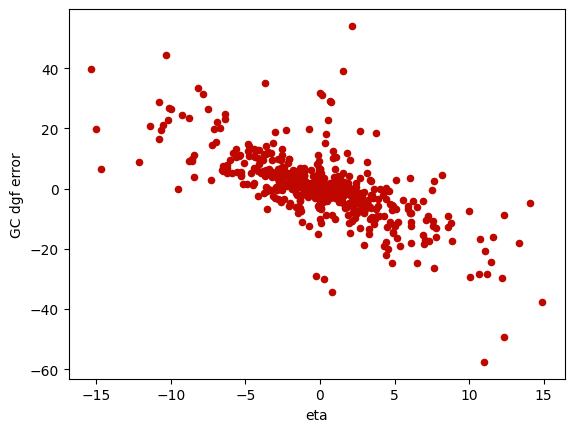

In [12]:
compounds["eta"] = eta_means
ax = compounds.rename(var_names, axis=1).plot.scatter("eta", var_names["cc_gc_diff"]).get_figure()
ax.savefig((PLOTS_DIR / "eta-GC-err-corr.png").absolute())

Make sure that cc_gc_diff is actually what we want. How to examine only the metabolites that are in the domain of S.T?

In [ ]:
compounds